In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_loss_acc(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train acc', 'val acc', 'train loss', 'val loss'], loc='upper left')
    plt.show()

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import h5py
import sys
from keras import Model
from keras.layers import Input, Embedding, Flatten, Dense, Dropout, LSTM, Conv1D
from keras.layers.wrappers import Bidirectional
from keras.utils.io_utils import HDF5Matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
np.set_printoptions(threshold=sys.maxsize)


In [3]:
#Test proteins have distances = 1.0 everywhere
#unique_protein_idx = np.where(np.sum(distance_matrix,axis=1) == 27031)[0]
#print(' '.join(distance_matrix.columns.values[unique_protein_idx]))
#sorted_similarity_indexes = np.sum(distance_matrix,axis=1).sort_values()

#get more common proteins like so:
#train_set = set()
#i = 0
#for protein_index, value in sorted_similarity_indexes.items():
#    similar_indexes = np.where(distance_matrix.iloc[protein_index,:] != 1.0)[0]
#    [train_set.add(element) for element in list(similar_indexes)]
#    
#    i+=1
#    if i > 1000:
#        #print(len(train_set))
#        break
#print(' '.join(distance_matrix.columns.values[list(train_set)]))    

In [8]:

input_dataset = 'data/dataset_sseq_singleseq.hdf5'
target_list_path = 'data/train_set'
test_list_path = 'data/test_set'
batch = 32
def get_model(convolutional = False):# This switches between a convolutional or a recurrent architecture 
    

    nb_epoch = 10
    batch = 32
    window = 31
    dropfrac = 0.5
    embed_size = 16
    bidir_size = 64

    #INPUTS timesteps are columns from the MSA
    inputs = Input(shape=(window,))
    embed = Embedding(21, embed_size, input_length=window, batch_input_shape=(batch, window))(inputs)

    bidir = Bidirectional(LSTM(bidir_size, return_sequences=True), merge_mode='ave')(embed)

    conv = Conv1D(32, 9, activation='relu')(embed)
    conv2 = Conv1D(64, 5, activation='relu')(conv)
    conv3 = Conv1D(128, 3, activation='relu')(conv2)

    if convolutional:
        dense = Dense(32)(Flatten()(conv2))
    else:
        dense = Dense(32)(Flatten()(bidir))

    dense2 = Dense(16)(dense)
    outputs = Dense(3, activation='softmax')(dense2)

    #MODEL
    model_sseq = tf.keras.Model(inputs, outputs)

    print('Compiling the model...')
    model_sseq.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    model_sseq.summary()
    
    return model_sseq

Look at the architecture above:
* What does putting the variable "convolutional" to False mean? What happens to the bidirectional layers when we are using a convolutional architecture?
* Which architecture would be best for this type of dataset in your opinion?
    

In [4]:
def count_steps(target_list_data, window=None, batch=None):
    
    n_targets = len(target_list_data)
    
    if window is None:
        return n_targets
    
    target_index = 0
    n_steps = 0
    for target in target_list_data:
        
        try:
            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs/' + target))  # length x max_depth
        except:
            continue

        length = X_batch.shape[0]
                                 
        n_steps += int(((length - window + 1) / batch))
    return n_steps
        
def generate_inputs_window(target_list_data, window=None, batch=None, shuffle=False):

    n_targets = len(target_list_data)
    if shuffle:
        random.shuffle(target_list_data)
        
    full_length = False
    if window is None:
        full_length = True
    
    target_index = 0
    
    while 1:
        
        target = target_list_data[target_index]
        target_index += 1
        target_index = target_index % n_targets

        # create numpy arrays of input data
        # and labels, from each line in the file
        try:
            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs/' + target))  # length x max_depth
        except:
            continue

        length, max_depth = X_batch.shape[0], X_batch.shape[1]
                                        # 0...00length00...0, max_depth
        if full_length:
            batch = length
            window = length
                    
        if not full_length: #submitting batches of windows
            X_batch = np.lib.pad(X_batch, [(int(window / 2), int(window / 2)), (0, 0)], 'constant', constant_values=(0, 0))
            X_batch_windows = []
            for i in range(length):
                X_batch_windows.append(X_batch[i:i + window, :1].reshape(window))
        else:
            X_batch_windows = X_batch[:, :1]
            
        labels_batch_sseq = np.squeeze(np.asarray(HDF5Matrix(input_dataset, 'labels_sseq/' + target)))
        
       # print(np.array(X_batch_windows).shape)
        
        for i in range(0, length, batch):
            # length x 1 (sparse, 3 class)
            yield (np.array(X_batch_windows)[i:i+batch], labels_batch_sseq[i:i+batch])
    
    target_list_data = target_list_file.readlines()


In [13]:
def count_steps_31(target_list_data, batch=None):
    
    n_targets = len(target_list_data)
    
    target_index = 0
    n_steps = 0
    for target in target_list_data:
        
        try:
            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs_windows/' + target))  # length x max_depth
        except:
            continue

        length = X_batch.shape[0]
                                 
        n_steps += int(((length - 31 + 1) / batch))
    return n_steps
        
def generate_inputs_window_31(X, y, target_list_data, batch=None, shuffle=False):

    n_targets = len(target_list_data)
    if shuffle:
        random.shuffle(target_list_data)
    
    target_index = 0
    while 1:
        
        target = target_list_data[target_index]
        target_index += 1
        target_index = target_index % n_targets

        # create numpy arrays of input data
        # and labels, from each line in the file
        try:
            X_batch = X[target]
        except:
            continue

        length = X_batch.shape[0]
                                        # 0...00length00...0, max_depth                    
            
        labels_batch_sseq = y[target]
        
       # print(np.array(X_batch_windows).shape)
        
        for i in range(0, length, batch):
            # length x 1 (sparse, 3 class)
            yield (X_batch[i:i+batch], labels_batch_sseq[i:i+batch])
    

def load_inputs_31(target_list_data, shuffle=False):

    X = {}
    y = {}
    
    n_targets = len(target_list_data)
    if shuffle:
        random.shuffle(target_list_data)
            
    target_index = 0
    
    #X = np.zeros((0,31))
    #y = np.zeros(0)

    for target_index in range(n_targets):

        target = target_list_data[target_index]

        try:
            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs_windows/' + target))  # length x max_depth
        except:
            continue

        length = X_batch.shape[0]
                                        # 0...00length00...0, max_depth                    
        
        X[target] = X_batch
        #y = np.concatenate((y,np.squeeze(np.asarray(HDF5Matrix(input_dataset, 'labels_sseq/' + target)))))
        y[target] = np.squeeze(np.asarray(HDF5Matrix(input_dataset, 'labels_sseq/' + target)))
    return X, y

Let's start by taking the classical approach of randomly splitting the data in a trainset and a validation set (95%/5%), train a network on the trainset and see what the score on the validation changes epoch by epoch:

In [14]:
import random

target_list_file = open(target_list_path)
target_list = target_list_file.readlines()
random.shuffle(target_list)
n_targets = len(target_list)
train_list = target_list[int(n_targets/20):] #95% train
validation_list = target_list[:int(n_targets/20)] #5% validation

validation_steps = count_steps_31(validation_list, batch)
print("Validation batches:", validation_steps)

Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.


/home/claudio/anaconda3/envs/nn_dl_python/lib/python3.7/site-packages/tensorflow/python/keras/utils/io_utils.py:89: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


Validation batches: 2370


In [8]:
## Un-comment this code if you want to reload the data from the .hdf5 file for some reason
#import pickle
#X,y = load_inputs_31(target_list, shuffle=False)
#pickle.dump((X,y), open("dataset_sseq_singleseq.pic",'wb'))

In [15]:
import pickle
(X,y) = pickle.load(open("data/dataset_sseq_singleseq.pic",'rb'))

In [78]:
batch=32
model_sseq = get_model(convolutional=True) #get a fresh model
hist = model_sseq.fit(generate_inputs_window_31(X,y,train_list, batch), 
               validation_data=generate_inputs_window_31(X,y,validation_list, batch), 
               epochs=50, steps_per_epoch=10000, validation_steps=validation_steps, batch_size=batch)


Compiling the model...
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 31, 16)            336       
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 23, 32)            4640      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 19, 64)            10304     
_________________________________________________________________
flatten_12 (Flatten)         (None, 1216)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                38944     
_________________________________________________________________
dense_46 (Dense)             (

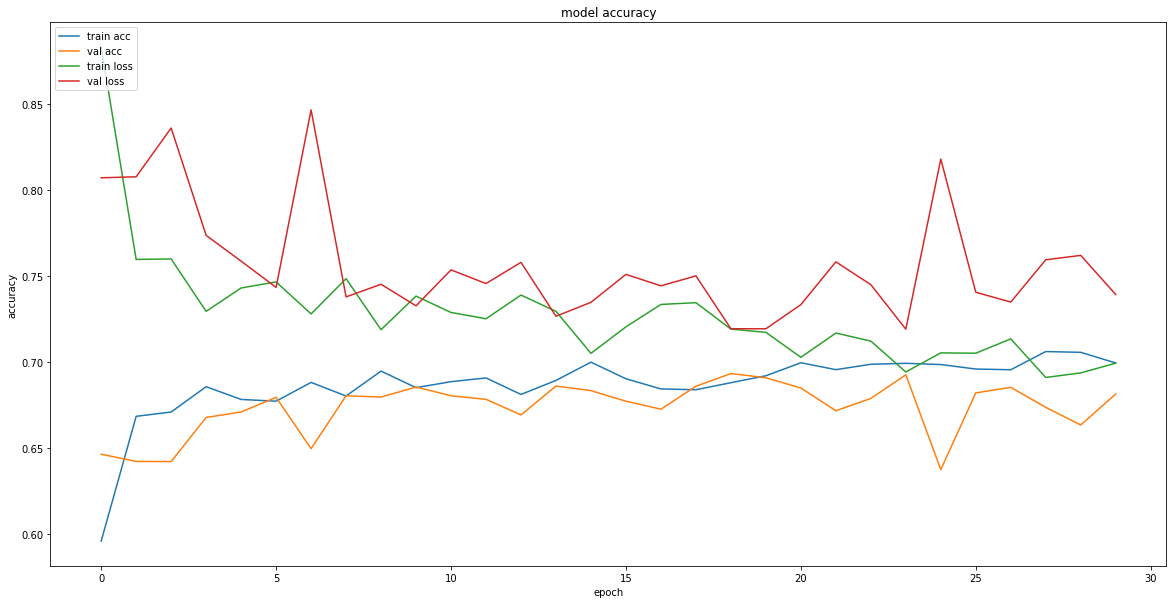

In [71]:
plot_loss_acc(hist)

* What is the best validation performance that you can extract from your Model?
* What would be the best naïve classifier for this dataset? How does the validation performance of your model compare to it?
* What do you think of randomly splitting the dataset this way? Can you think of a better way of doing it? Can you think of a _worse_ day of doing it?

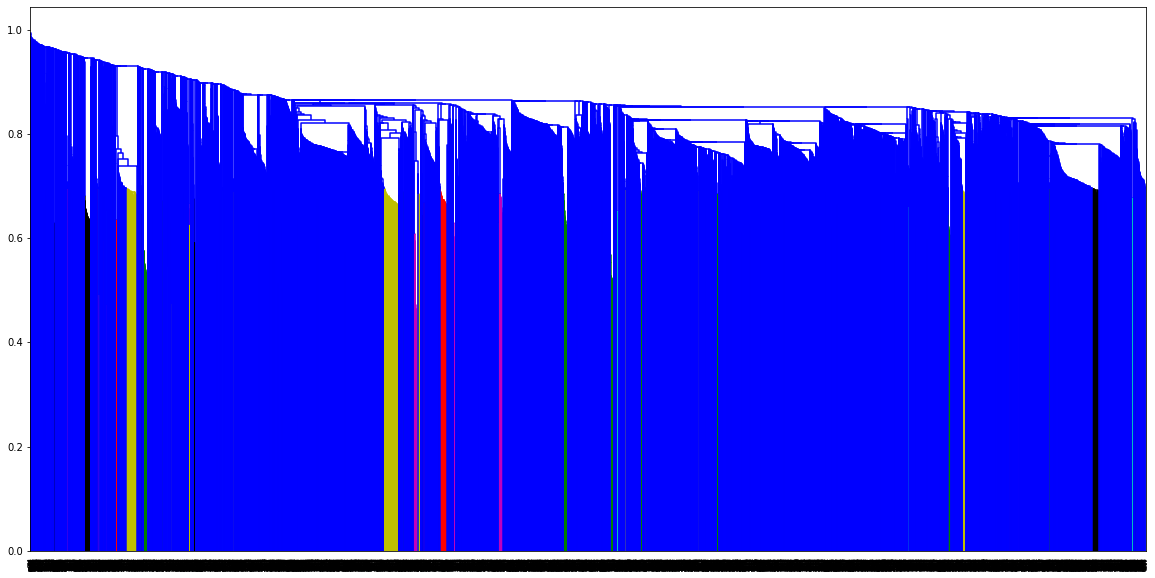

In [12]:
distance_matrix = pd.read_csv('data/trainset_distance_matrix.tsv', sep='\t')
dists = squareform(distance_matrix)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix)
plt.show()

In [39]:
cluster_assignments = fcluster(linkage_matrix,criterion='distance', t=0.7)
print(len(cluster_assignments), np.max(cluster_assignments))

target_list_file = open(target_list_path)
target_list = target_list_file.readlines()

train_list_cluster = []
validation_list_cluster = []
validation_size_limit = int(n_targets/20)

for i in range(1,np.max(cluster_assignments)+1):
    index_this_cluster = np.where(cluster_assignments == i)[0]
    if len(validation_list_cluster) < validation_size_limit:
        validation_list_cluster += [target_list[element] for element in index_this_cluster]
    else:
        train_list_cluster += [target_list[element] for element in index_this_cluster]

random.shuffle(train_list_cluster)
validation_steps_cluster = count_steps_31(validation_list_cluster, batch)
print("Validation batches:", validation_steps_cluster)

6546 5363
403 6143 327


In [79]:


model_sseq2 = get_model(convolutional=True) #get a fresh model

hist2 = model_sseq2.fit(generate_inputs_window_31(X,y,train_list_cluster, batch), 
               validation_data=generate_inputs_window_31(X,y,validation_list_cluster, batch), 
               epochs=50, steps_per_epoch=10000, validation_steps=validation_steps_cluster, batch_size=batch)


Compiling the model...
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 31, 16)            336       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 23, 32)            4640      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 19, 64)            10304     
_________________________________________________________________
flatten_13 (Flatten)         (None, 1216)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                38944     
_________________________________________________________________
dense_49 (Dense)             (

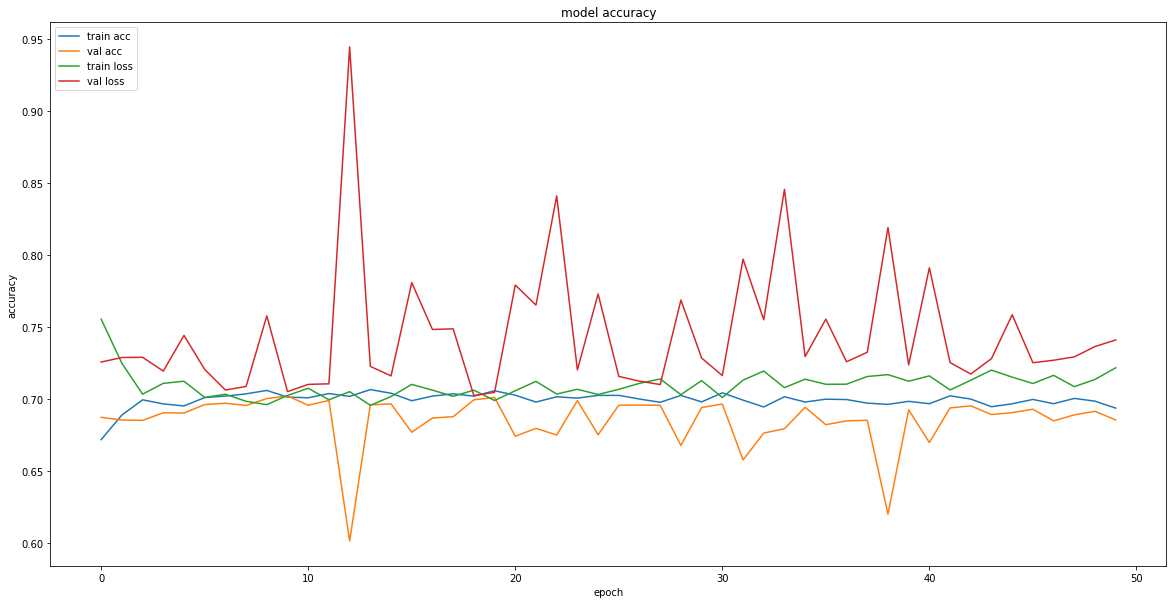

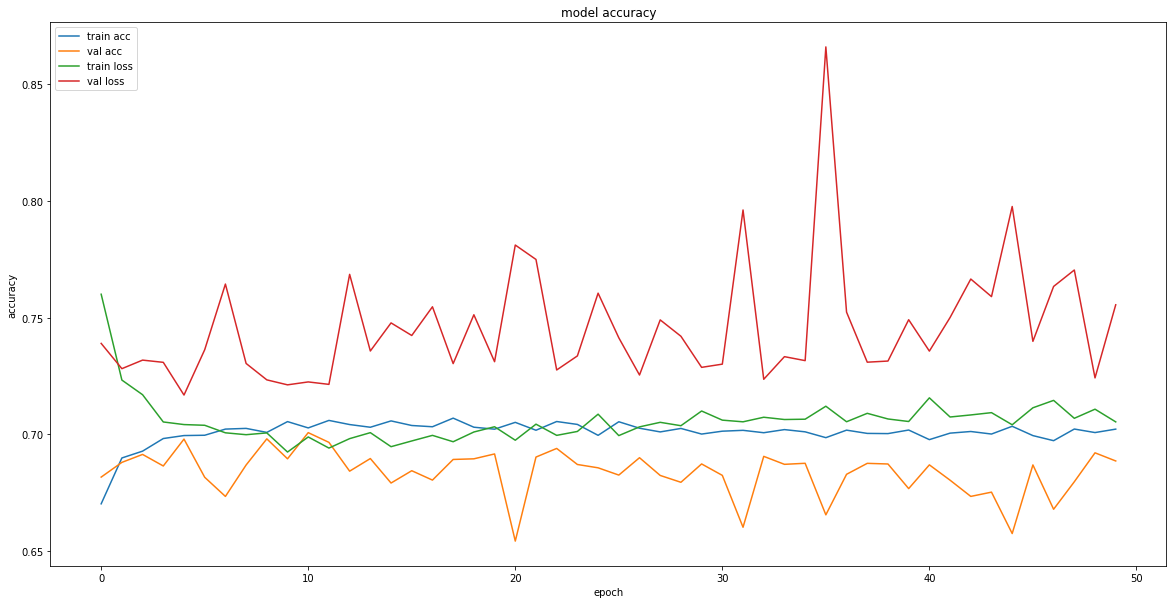

In [82]:
plot_loss_acc(hist)
plot_loss_acc(hist2)